In [30]:
"""
Basic 1 column CNN comparing between GFS and RAP data
This is just the inital validation for the CNN model for climate models
More later
Really simple code, but works- my first CNN model
"""
import numpy as np
import pandas as pd
import xarray as xr
# TODO move to top this and CONFIGS
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import logging

# Log config
logging.basicConfig(
    level=logging.INFO,                           
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.StreamHandler(),                   
        logging.FileHandler("CNN.log")    
    ]
)

logger = logging.getLogger(__name__)  


EPOCHS = 200


VAR_CHANNELS = ["delta_qv_physics", "delta_t_physics", "plev_channel"]  # add more variables as needed




LEVEL_DIM = "newlev"
TIME_DIM = "time"
SAMPLE_DIM = "sample"


In [31]:
# Data preparation 
def set_time_coordinates(ds, start_time="2016-08-11T00:00", freq="3H"):
    """
    Assigns a real UTC time coordinate to the dataset
    Args:
        ds: Input dataset that has a dimension named 'init_time'.
        start_time: The start timestamp in ISO format (default '2016-08-11T00:00').
        freq: Time step spacing, e.g. '3H' for 3-hourly data.

    Returns:
        ds: Dataset with a new 'time' coordinate and 'init_time' replaced.

    """
    n = ds.sizes["init_time"]
    t0 = np.datetime64(start_time)
    time = pd.date_range(t0, periods=n, freq=freq).to_numpy()

    ds = ds.assign_coords(time=("init_time", time))
    ds = ds.swap_dims({"init_time": "time"})
    return ds


def apply_misc_changes(ds: xr.Dataset) -> xr.Dataset:
    """
    MISC data edits
      1. Removes final 4 timesteps (indices 241–244).
      2. Sets all data at 2016-08-31 18:00 UTC to NaN.

    Args:
        ds: Dataset that has a 'time' coordinate (output of set_time_coordinates).

    Returns
        ds: Modified dataset.
    """
    # Remove final timesteps
    ds = ds.isel(time=slice(0, -4))

    # Set 2016-08-31 18:00 UTC to NaN
    target_time = np.datetime64("2016-08-31T18:00")
    if target_time in ds.time.values:
        ds = ds.copy()  # avoid modifying in-place
        ds.loc[dict(time=target_time)] = np.nan

    return ds



def compute_hourly_level_stats(train_ds: xr.Dataset, time_dim="time", level_dim="newlev", reduce_over=None):
    """
    TODO add datatype in funciton header
    Compute mean/std for each UTC hour × pressure level from TRAIN set.
    Only variables with both time and level dims are handled.
    """
    stats = {}
    for var in train_ds.data_vars:
        da = train_ds[var]
        if (np.issubdtype(da.dtype, np.number) and time_dim in da.dims and level_dim in da.dims):
            reduce_dims = [time_dim]
            if reduce_over:
                reduce_dims = list(dict.fromkeys(reduce_dims + list(reduce_over)))

            g = da.groupby(f"{time_dim}.hour")          # <-- no assign_coords needed
            mean = g.mean(dim=reduce_dims, skipna=True)
            std  = g.std (dim=reduce_dims, skipna=True)

            stats[var] = {"mean": mean, "std": std, "level_dim": level_dim}
    return stats


def apply_hourly_level_normalisation(ds: xr.Dataset, stats: dict, time_dim="time", level_dim="newlev"):
    """
    Apply joint (UTC hour × pressure level) normalisation using TRAIN stats.
    """
    ds_norm = ds.copy()
    hour_idx = xr.DataArray(ds[time_dim].dt.hour.values, dims=time_dim, name="hour")  # <-- values

    for var, s in stats.items():
        if var not in ds_norm:
            continue
        da = ds_norm[var]
        if time_dim in da.dims and level_dim in da.dims:
            mean = s["mean"].sel(hour=hour_idx)
            std  = s["std"].sel(hour=hour_idx)
            safe_std = xr.where((std == 0) | (~np.isfinite(std)), 1.0, std)
            ds_norm[var] = (da - mean) / safe_std
    return ds_norm

# TODO: maybe remove
def add_positional_channel(ds, p_norm, name="plev_channel"):
    shape = (ds.sizes["sample"], ds.sizes["time"], ds.sizes["newlev"])
    p3 = np.broadcast_to(p_norm, shape).astype("float32")
    da = xr.DataArray(p3, dims=("sample","time","newlev"))
    return ds.assign(**{name: da})

# TODO this is reused below, maybe integrate
def compute_nan_fraction(
    ds: xr.Dataset,
    var_names,
    sample_dim=SAMPLE_DIM,
    time_dim=TIME_DIM,
    level_dim=LEVEL_DIM,
):
    """
    Compute NaN diagnostics for the given variables.
    """
    # Gather per-var arrays shaped [S, T, L]
    arrays = []
    for v in var_names:
        if v in ds and (sample_dim in ds[v].dims and time_dim in ds[v].dims and level_dim in ds[v].dims):
            arrays.append(ds[v].transpose(sample_dim, time_dim, level_dim).values)
        else:
            raise ValueError(f"{v} missing or has wrong dims in dataset.")

    # Stack to [S, T, C, L]
    data = np.stack(arrays, axis=2)

    # Fraction of NaNs over C×L for each (S,T)
    nan_fraction = np.isnan(data).mean(axis=(2, 3))  # [S, T] in [0,1]

    # Any-NaN boolean over channels×levels for each (S,T)
    any_nan_bool = np.isnan(data).any(axis=(2, 3))   # [S, T], True if any missing

    # Wrap as DataArray for convenience
    nan_frac_da = xr.DataArray(
        nan_fraction,
        dims=(sample_dim, time_dim),
        coords={sample_dim: ds[sample_dim], time_dim: ds[time_dim]},
        name="nan_fraction"
    )

    any_nan_da = xr.DataArray(
        any_nan_bool,
        dims=(sample_dim, time_dim),
        coords={sample_dim: ds[sample_dim], time_dim: ds[time_dim]},
        name="has_any_nan"
    )

    # Global stats
    S = data.shape[0]
    T = data.shape[1]
    total_pairs = int(S * T)
    pairs_with_any_nan = int(any_nan_bool.sum())
    pairs_with_any_nan_pct = 100.0 * pairs_with_any_nan / max(1, total_pairs)

    flat = nan_fraction.reshape(-1)
    mean_pct = float(flat.mean() * 100.0)
    std_pct  = float(flat.std()  * 100.0)
    max_pct  = float(flat.max()  * 100.0)

    # Per-sample (# of times with any NaN) and per-time (# of samples with any NaN)
    per_sample_any_nan_count = any_nan_da.sum(dim=time_dim).astype("int64")  # [sample]
    per_time_any_nan_count   = any_nan_da.sum(dim=sample_dim).astype("int64")# [time]

    summary = {
        "mean_%": mean_pct,
        "std_%":  std_pct,
        "max_%":  max_pct,
        "total_pairs": total_pairs,
        "pairs_with_any_nan": pairs_with_any_nan,
        "pairs_with_any_nan_%": pairs_with_any_nan_pct,
        "per_sample_any_nan_count": per_sample_any_nan_count,  # DataArray
        "per_time_any_nan_count":   per_time_any_nan_count,    # DataArray
    }

    # If you also want to keep the boolean grid in the dataset, return it too:
    return nan_frac_da, summary, any_nan_da



def data_processing_pipeline(model_datasets):
    """
    TODO ADD DESCRIPTION-combine normalise
    """

    labelled_datasets = []

    for idx, (name, ds) in enumerate(model_datasets.items()):
        # assign both numeric and string labels
        ds_labeled = ds.assign_coords(model_id=idx, model_name=name)
        labelled_datasets.append(ds_labeled)


    # concatenate along a new dimension 
    ds_combined = xr.concat(labelled_datasets, dim="sample")


    ds_combined = set_time_coordinates(ds_combined)
    ds_combined = apply_misc_changes(ds_combined)


    # Split validation/train
    ds_train = ds_combined.isel(time=slice(0, 180))
    ds_validation  = ds_combined.isel(time=slice(181, 220))
    ds_test  = ds_combined.isel(time=slice(220, 240)) 

    #Normalise
    norm_stats = compute_hourly_level_stats(ds_train)
    ds_train_norm = apply_hourly_level_normalisation(ds_train, norm_stats)
    ds_validation_norm = apply_hourly_level_normalisation(ds_validation, norm_stats)
    ds_test_norm = apply_hourly_level_normalisation(ds_test, norm_stats)

    #Add normalised pressure coord, a height hint for the CNN, note that I think maybe the pooling later will remove some of this info, so this is essentially adding t back in
    p = ds_train_norm["plev"].values.astype("float32")
    p_norm = (p - p.mean()) / (p.std() + 1e-8)

    ds_train_norm = add_positional_channel(ds_train_norm, p_norm, "plev_channel")
    ds_validation_norm  = add_positional_channel(ds_validation_norm,  p_norm, "plev_channel")
    ds_test_norm  = add_positional_channel(ds_test_norm,  p_norm, "plev_channel")

    # NAN stats
    nan_frac_train, train_summary, train_any = compute_nan_fraction(ds_train_norm, VAR_CHANNELS)
    nan_frac_validation,  validation_summary,  validation_any  = compute_nan_fraction(ds_validation_norm,  VAR_CHANNELS)
    nan_frac_test,  test_summary,  test_any  = compute_nan_fraction(ds_test_norm,  VAR_CHANNELS)

    # TODO add nan_frac to ds??

    # Log both % and counts
    logger.info(
        "Train NaN fraction: mean %.2f%% ± %.2f%% (max %.2f%%) | pairs_with_any_nan=%d/%d (%.2f%%)",
        train_summary["mean_%"], train_summary["std_%"], train_summary["max_%"],
        train_summary["pairs_with_any_nan"], train_summary["total_pairs"], train_summary["pairs_with_any_nan_%"]
    )
    logger.info(
        "validation  NaN fraction: mean %.2f%% ± %.2f%% (max %.2f%%) | pairs_with_any_nan=%d/%d (%.2f%%)",
        validation_summary["mean_%"],  validation_summary["std_%"],  validation_summary["max_%"],
        validation_summary["pairs_with_any_nan"], validation_summary["total_pairs"], validation_summary["pairs_with_any_nan_%"]
    )
    logger.info(
        "Test  NaN fraction: mean %.2f%% ± %.2f%% (max %.2f%%) | pairs_with_any_nan=%d/%d (%.2f%%)",
        test_summary["mean_%"],  test_summary["std_%"],  test_summary["max_%"],
        test_summary["pairs_with_any_nan"], test_summary["total_pairs"], test_summary["pairs_with_any_nan_%"]
    )


    

    return ds_train_norm, ds_validation_norm, ds_test_norm





ds_gfs = xr.open_dataset("GFS_merged_latid197.nc")
ds_rap = xr.open_dataset("RAP_merged_latid197.nc")

# For one column for now
target_lon = 51.5
# Pick the nearest grid column at that longitude and drop the lon dimension
gfs_col = ds_gfs.sel(lon=target_lon, method="nearest", drop=True)
rap_col = ds_rap.sel(lon=target_lon, method="nearest", drop=True)


model_datasets = {
    "GFS": gfs_col,
    "RAP": rap_col
}

ds_train, ds_validation, ds_test_norm = data_processing_pipeline(model_datasets)



C:\Users\danna\AppData\Local\Temp\ipykernel_32304\1040155924.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range(t0, periods=n, freq=freq).to_numpy()
2025-11-10 04:00:02,797 [INFO] Train NaN fraction: mean 0.37% ± 4.96% (max 66.67%) | pairs_with_any_nan=2/360 (0.56%)
2025-11-10 04:00:02,797 [INFO] validation  NaN fraction: mean 0.00% ± 0.00% (max 0.00%) | pairs_with_any_nan=0/78 (0.00%)
2025-11-10 04:00:02,797 [INFO] Test  NaN fraction: mean 0.00% ± 0.00% (max 0.00%) | pairs_with_any_nan=0/40 (0.00%)


In [ ]:
   

#TODO maybe make better and more efficient by merginf build_xy_from_xr to the data pipeline
#  build (X, y) from an xarray.Dataset
def build_xy_from_xr(ds: xr.Dataset, var_names, sample_dim = SAMPLE_DIM, level_dim=LEVEL_DIM, time_dim=TIME_DIM):
    """
    Returns:
      X: np.ndarray of shape [N_examples, C, L]
      y: np.ndarray of shape [N_examples]  (class id from model_id)
    One example per (model, time).
    """
    
    # Safety checks
    # TODO this needed??
    for v in var_names:
        if v not in ds:
            raise ValueError(f"Variable '{v}' not found in dataset.")

    # Extract labels from the dataset coord 'model_id' (per-sample)
    # We will broadcast to (sample, time)
    model_ids = ds["model_id"].values  # shape [n_models]
    n_models = model_ids.shape[0]
    n_times  = ds.sizes[time_dim]
    n_levels = ds.sizes[level_dim]
    n_channels = len(var_names)

    # Stack per (model, time)
    # Build data array per variable -> shape [sample, time, newlev]
    arrays = []
    for v in var_names:
        a = ds[v].transpose(sample_dim, time_dim, level_dim).values  # [S, T, L]
        arrays.append(a)
    # Stack channels -> [S, T, C, L]
    data = np.stack(arrays, axis=2)

    # Flatten (model, time) -> N examples
    X = data.reshape(n_models * n_times, n_channels, n_levels)

    # Label per (model, time): repeat model_id across time
    y = np.repeat(model_ids, n_times)


    # TODO make smth more sophsitcated maybe by adding another channel
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    return X.astype(np.float32), y.astype(np.int64)

X_train, y_train = build_xy_from_xr(ds_train, VAR_CHANNELS)
X_validation,  y_validation  = build_xy_from_xr(ds_validation,  VAR_CHANNELS)
X_test,  y_test  = build_xy_from_xr(ds_test_norm,  VAR_CHANNELS)

logger.info(f"Train: X={X_train.shape} y={y_train.shape}")
logger.info(f"Validation: X={X_validation.shape} y={y_validation.shape}")
logger.info(f"Test: X={X_test.shape} y={y_test.shape}")

# TODO not sure but proabbaly can be merged witg data loader
class ColumnDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  
        self.y = torch.from_numpy(y)  

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ColumnDataset(X_train, y_train)
validation_ds  = ColumnDataset(X_validation,  y_validation)
test_ds  = ColumnDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
validation_loader  = DataLoader(validation_ds,  batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)


# Input: [B, C, L] where C=#channels (2 here), L=#levels (46)

num_classes = len(np.unique(y_train))

class SimpleLevelCNN(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=15, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(16),

            # TODO separate out CNN blocks into different things, like self.block2
            nn.Conv1d(16, 32, kernel_size=15, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            nn.AdaptiveAvgPool1d(1),  
            # TODO separate out CNN blocks into different things, like self.block2

        )
        self.head = nn.Linear(32, n_classes)

    def forward(self, x):
        z = self.net(x)           # [B, 32, 1]
        z = z.squeeze(-1)         # [B, 32]
        logits = self.head(z)     # [B, n_classes]
        return logits

model = SimpleLevelCNN(in_channels=len(VAR_CHANNELS), n_classes=num_classes)

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05) 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = EPOCHS

def evaluate(loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss_sum += loss.item() * yb.size(0)

            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return loss_sum / total, correct / total

for epoch in range(1, epochs + 1):
    model.train()
    running = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * yb.size(0)

    train_loss = running / len(train_ds)
    val_loss, val_acc = evaluate(validation_loader)
    logger.info(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | validation_loss={val_loss:.4f} | validation_acc={val_acc:.3f}")

# Evaluation
model.eval()

# Full test-set metrics
test_loss, test_acc = evaluate(test_loader)
logger.info("FINAL TEST | loss=%.4f | acc=%.3f", test_loss, test_acc)



# all_preds = []
# all_true  = []

# with torch.no_grad():  # or torch.inference_mode()
#     for Xb, yb in test_loader:
#         Xb = Xb.to(device)
#         logits = model(Xb)
#         preds = logits.argmax(dim=1).cpu().numpy()
#         all_preds.append(preds)
#         all_true.append(yb.numpy())

# y_pred = np.concatenate(all_preds)
# y_true = np.concatenate(all_true)

# logger.info("Test N=%d | classes=%d", len(y_true), len(np.unique(y_true)))



2025-11-10 04:00:03,799 [INFO] Train: X=(360, 3, 46) y=(360,)
2025-11-10 04:00:03,800 [INFO] Validation: X=(78, 3, 46) y=(78,)
2025-11-10 04:00:03,800 [INFO] Test: X=(40, 3, 46) y=(40,)


2025-11-10 04:00:03,836 [INFO] Epoch 01 | train_loss=0.6962 | validation_loss=0.6886 | validation_acc=0.513
2025-11-10 04:00:03,862 [INFO] Epoch 02 | train_loss=0.6542 | validation_loss=0.6931 | validation_acc=0.462
2025-11-10 04:00:03,886 [INFO] Epoch 03 | train_loss=0.6211 | validation_loss=0.6902 | validation_acc=0.474
2025-11-10 04:00:03,911 [INFO] Epoch 04 | train_loss=0.5937 | validation_loss=0.6813 | validation_acc=0.538
2025-11-10 04:00:03,934 [INFO] Epoch 05 | train_loss=0.5692 | validation_loss=0.6774 | validation_acc=0.603
2025-11-10 04:00:03,960 [INFO] Epoch 06 | train_loss=0.5397 | validation_loss=0.6645 | validation_acc=0.641
2025-11-10 04:00:03,985 [INFO] Epoch 07 | train_loss=0.5213 | validation_loss=0.6470 | validation_acc=0.628
2025-11-10 04:00:04,007 [INFO] Epoch 08 | train_loss=0.4938 | validation_loss=0.6340 | validation_acc=0.692
2025-11-10 04:00:04,030 [INFO] Epoch 09 | train_loss=0.4734 | validation_loss=0.6168 | validation_acc=0.705
2025-11-10 04:00:04,055 [INF

In [28]:
ds_test_norm

<xarray.Dataset> Size: 8kB
Dimensions:            (sample: 2, time: 1, newlev: 46, plev: 46, level: 127)
Coordinates:
  * time               (time) datetime64[ns] 8B 2016-09-10
  * plev               (plev) float64 368B 9.8e+04 9.6e+04 ... 1e+04 8e+03
  * level              (level) int64 1kB 0 1 2 3 4 5 ... 121 122 123 124 125 126
    lat                float32 4B 4.5
    model_id           (sample) int32 8B 0 1
    model_name         (sample) <U3 24B 'GFS' 'RAP'
    hour               (time) int64 8B 0
Dimensions without coordinates: sample, newlev
Data variables:
    pressure_f         (sample, time, newlev) float64 736B 0.0 0.0 ... 0.0 0.0
    delta_qv_dynamics  (sample, time, newlev) float64 736B -0.2081 ... -0.3152
    delta_t_dynamics   (sample, time, newlev) float64 736B -2.333 ... 0.7002
    delta_u_dynamics   (sample, time, newlev) float64 736B -2.293 ... -2.372
    delta_v_dynamics   (sample, time, newlev) float64 736B 0.561 0.675 ... 1.142
    delta_qv_physics   (sample, time, newlev) float64 736B 1.019 ... -0.3781
    delta_u_physics    (sample, time, newlev) float64 736B 1.989 ... 2.352
    delta_v_physics    (sample, time, newlev) float64 736B 0.2403 ... 0.5448
    delta_t_physics    (sample, time, newlev) float64 736B 2.371 ... 0.4699
    plev_channel       (sample, time, newlev) float32 368B 1.695 ... -1.695

In [26]:
print(gfs_col["newlev"].values)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [27]:
print(rap_col["newlev"].values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [7]:
ds= gfs_col

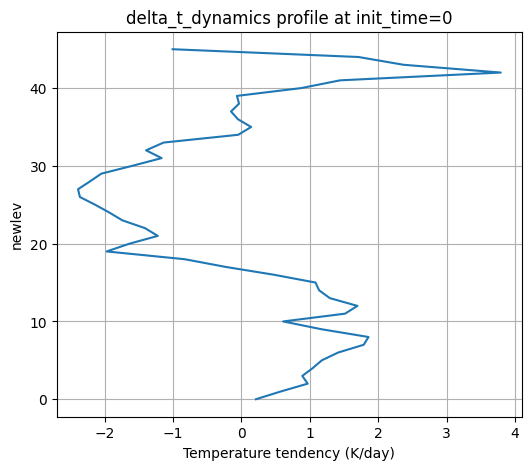

In [8]:
import matplotlib.pyplot as plt

var = "delta_t_dynamics"            # or "delta_t_physics"
it  = 0                             # choose an init_time index (e.g., 0)

ycoord = "newlev"                   # vertical coord to plot against
x      = ds[var].isel(init_time=it)
y      = ds[ycoord]

plt.figure(figsize=(6,5))
plt.plot(x, y)
plt.xlabel("Temperature tendency (K/day)")   # adjust units/label if needed
plt.ylabel(ycoord)
plt.title(f"{var} profile at init_time={ds.init_time.values[it]}")
plt.grid(True)
plt.show()


In [ ]:
gfs_col


<xarray.Dataset> Size: 813kB
Dimensions:            (init_time: 245, newlev: 46, plev: 46, level: 127)
Coordinates:
  * plev               (plev) float64 368B 9.8e+04 9.6e+04 ... 1e+04 8e+03
  * level              (level) int64 1kB 0 1 2 3 4 5 ... 121 122 123 124 125 126
    lat                float32 4B ...
Dimensions without coordinates: init_time, newlev
Data variables:
    pressure_f         (init_time, newlev) float64 90kB ...
    delta_qv_dynamics  (init_time, newlev) float64 90kB ...
    delta_t_dynamics   (init_time, newlev) float64 90kB ...
    delta_u_dynamics   (init_time, newlev) float64 90kB ...
    delta_v_dynamics   (init_time, newlev) float64 90kB ...
    delta_qv_physics   (init_time, newlev) float64 90kB ...
    delta_u_physics    (init_time, newlev) float64 90kB ...
    delta_v_physics    (init_time, newlev) float64 90kB ...
    delta_t_physics    (init_time, newlev) float64 90kB ...

In [ ]:
ds_validation

<xarray.Dataset> Size: 282kB
Dimensions:            (sample: 2, time: 40, newlev: 46, plev: 46, level: 127)
Coordinates:
  * time               (time) datetime64[ns] 320B 2016-09-05 ... 2016-09-09T2...
  * plev               (plev) float64 368B 9.8e+04 9.6e+04 ... 1e+04 8e+03
  * level              (level) int64 1kB 0 1 2 3 4 5 ... 121 122 123 124 125 126
    lat                float32 4B 4.5
    model_id           (sample) int64 16B 0 1
    model_name         (sample) <U3 24B 'GFS' 'RAP'
    hour               (time) int64 320B 0 3 6 9 12 15 18 ... 3 6 9 12 15 18 21
Dimensions without coordinates: sample, newlev
Data variables:
    pressure_f         (sample, time, newlev) float64 29kB 0.0 0.0 ... 0.0 0.0
    delta_qv_dynamics  (sample, time, newlev) float64 29kB -0.06952 ... 0.02013
    delta_t_dynamics   (sample, time, newlev) float64 29kB 0.3646 ... -0.1708
    delta_u_dynamics   (sample, time, newlev) float64 29kB -0.1294 ... -1.434
    delta_v_dynamics   (sample, time, newlev) float64 29kB -0.0797 ... -0.7178
    delta_qv_physics   (sample, time, newlev) float64 29kB -2.157 ... -0.4107
    delta_u_physics    (sample, time, newlev) float64 29kB 0.6552 ... -3.092
    delta_v_physics    (sample, time, newlev) float64 29kB 2.378 1.769 ... 1.878
    delta_t_physics    (sample, time, newlev) float64 29kB 3.795 ... -0.1447
    plev_channel       (sample, time, newlev) float32 15kB 1.695 ... -1.695

In [ ]:
# TODO move to top this and CONFIGS
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader




VAR_CHANNELS = ["delta_qv_physics", "delta_t_physics", "plev_channel"]  # add more variables as needed




LEVEL_DIM = "newlev"
TIME_DIM = "time"
SAMPLE_DIM = "sample"   

#TODO maybe make better and more efficient by merginf build_xy_from_xr to the data pipeline
#  build (X, y) from an xarray.Dataset
def build_xy_from_xr(ds: xr.Dataset, var_names, sample_dim = SAMPLE_DIM, level_dim=LEVEL_DIM, time_dim=TIME_DIM):
    """
    Returns:
      X: np.ndarray of shape [N_examples, C, L]
      y: np.ndarray of shape [N_examples]  (class id from model_id)
    One example per (model, time).
    """
    
    # Safety checks
    # TODO this needed??
    for v in var_names:
        if v not in ds:
            raise ValueError(f"Variable '{v}' not found in dataset.")

    # Extract labels from the dataset coord 'model_id' (per-sample)
    # We will broadcast to (sample, time)
    model_ids = ds["model_id"].values  # shape [n_models]
    n_models = model_ids.shape[0]
    n_times  = ds.sizes[time_dim]
    n_levels = ds.sizes[level_dim]
    n_channels = len(var_names)

    # Stack per (model, time)
    # Build data array per variable -> shape [sample, time, newlev]
    arrays = []
    for v in var_names:
        a = ds[v].transpose(sample_dim, time_dim, level_dim).values  # [S, T, L]
        arrays.append(a)
    # Stack channels -> [S, T, C, L]
    data = np.stack(arrays, axis=2)

    # Flatten (model, time) -> N examples
    X = data.reshape(n_models * n_times, n_channels, n_levels)

    # Label per (model, time): repeat model_id across time
    y = np.repeat(model_ids, n_times)


    # TODO make smth more sophsitcated maybe by adding another channel
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    return X.astype(np.float32), y.astype(np.int64)

X_train, y_train = build_xy_from_xr(ds_train, VAR_CHANNELS)
X_validation,  y_validation  = build_xy_from_xr(ds_validation,  VAR_CHANNELS)

print("Train:", X_train.shape, y_train.shape)
print("validation :", X_validation.shape,  y_validation.shape)

# TODO not sure but proabbaly can be merged witg data loader
class ColumnDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # float32
        self.y = torch.from_numpy(y)  # int64

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ColumnDataset(X_train, y_train)
validation_ds  = ColumnDataset(X_validation,  y_validation)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
validation_loader  = DataLoader(validation_ds,  batch_size=256, shuffle=False)


# Input: [B, C, L] where C=#channels (2 here), L=#levels (46)

num_classes = len(np.unique(y_train))

class SimpleLevelCNN(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=15, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(16),

            # TODO separate out CNN blocks into different things, like self.block2
            nn.Conv1d(16, 32, kernel_size=15, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),

            nn.AdaptiveAvgPool1d(1),  
            # TODO separate out CNN blocks into different things, like self.block2

        )
        self.head = nn.Linear(32, n_classes)

    def forward(self, x):
        z = self.net(x)           # [B, 32, 1]
        z = z.squeeze(-1)         # [B, 32]
        logits = self.head(z)     # [B, n_classes]
        return logits

model = SimpleLevelCNN(in_channels=len(VAR_CHANNELS), n_classes=num_classes)

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05) 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 500

def evaluate(loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss_sum += loss.item() * yb.size(0)

            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return loss_sum / total, correct / total

for epoch in range(1, epochs + 1):
    model.train()
    running = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * yb.size(0)

    train_loss = running / len(train_ds)
    val_loss, val_acc = evaluate(validation_loader)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | validation_loss={val_loss:.4f} | validation_acc={val_acc:.3f}")

# Check
model.eval()
with torch.no_grad():
    Xb, yb = next(iter(validation_loader))
    Xb = Xb.to(device)
    logits = model(Xb)
    preds = logits.argmax(dim=1).cpu().numpy()

print("First 10 true vs pred:", list(zip(yb[:100].numpy(), preds[:100])))


Train: (400, 3, 46) (400,)
Test : (80, 3, 46) (80,)


TypeError: object of type 'ColumnDataset' has no len()

In [ ]:
# TODO move to top this and CONFIGS
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader




VAR_CHANNELS = ["delta_qv_physics", "delta_t_physics", "plev_channel"]  # add more variables as needed




LEVEL_DIM = "newlev"
TIME_DIM = "time"
SAMPLE_DIM = "sample"   

#TODO maybe make better and more efficient by merginf build_xy_from_xr to the data pipeline
#  build (X, y) from an xarray.Dataset
def build_xy_from_xr(ds: xr.Dataset, var_names, sample_dim = SAMPLE_DIM, level_dim=LEVEL_DIM, time_dim=TIME_DIM):
    """
    Returns:
      X: np.ndarray of shape [N_examples, C, L]
      y: np.ndarray of shape [N_examples]  (class id from model_id)
    One example per (model, time).
    """
    
    # Safety checks
    # TODO this needed??
    for v in var_names:
        if v not in ds:
            raise ValueError(f"Variable '{v}' not found in dataset.")

    # Extract labels from the dataset coord 'model_id' (per-sample)
    # We will broadcast to (sample, time)
    model_ids = ds["model_id"].values  # shape [n_models]
    n_models = model_ids.shape[0]
    n_times  = ds.sizes[time_dim]
    n_levels = ds.sizes[level_dim]
    n_channels = len(var_names)

    # Stack per (model, time)
    # Build data array per variable -> shape [sample, time, newlev]
    arrays = []
    for v in var_names:
        a = ds[v].transpose(sample_dim, time_dim, level_dim).values  # [S, T, L]
        arrays.append(a)
    # Stack channels -> [S, T, C, L]
    data = np.stack(arrays, axis=2)

    # Flatten (model, time) -> N examples
    X = data.reshape(n_models * n_times, n_channels, n_levels)

    # Label per (model, time): repeat model_id across time
    y = np.repeat(model_ids, n_times)

    # Replace NaNs with 0 -HMMMMM I'm not sure I like this, maybe should dropsample alltogether
    # TODO again it seems like especially this should be in the data pipeline
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    return X.astype(np.float32), y.astype(np.int64)

X_train, y_train = build_xy_from_xr(ds_train, VAR_CHANNELS)
X_validation,  y_validation  = build_xy_from_xr(ds_validation,  VAR_CHANNELS)

In [5]:
X_train

array([[[-0.1064603 , -0.12775072, -0.5874851 , ...,  0.43887445,
         -0.2050845 , -0.22322746],
        [-0.50806487, -0.48813534,  0.26781696, ..., -1.5852728 ,
          0.14673619, -0.54239595],
        [ 1.6947982 ,  1.6194738 ,  1.5441494 , ..., -1.5441494 ,
         -1.6194738 , -1.6947982 ]],

       [[ 0.3824309 , -0.8149009 , -0.8771793 , ..., -0.04982245,
          0.80949455, -0.03059787],
        [-0.19801722,  0.667466  ,  0.86551535, ..., -2.638442  ,
         -1.0643829 ,  1.5591865 ],
        [ 1.6947982 ,  1.6194738 ,  1.5441494 , ..., -1.5441494 ,
         -1.6194738 , -1.6947982 ]],

       [[ 0.9408831 ,  0.7307425 ,  0.02506378, ..., -0.10299438,
         -0.02763639,  0.0247813 ],
        [ 0.9847951 , -0.19927849, -0.13003556, ..., -1.0570655 ,
          0.24678892,  0.30145812],
        [ 1.6947982 ,  1.6194738 ,  1.5441494 , ..., -1.5441494 ,
         -1.6194738 , -1.6947982 ]],

       ...,

       [[-0.43954867,  0.09165435,  0.5553798 , ...,  0.0077223

In [ ]:
"""
Callbacks- early stopping- every 20, learnign rate- every 10- divide by 2 if not improved
Have validaiton data- 5 days. validation is completely unseen

Create pliots for one column exmaple
Work on XAI for this column- integrated gradients or grad cam- represent on plot of column with colours smth lie that. Former probs better
"""
#notes
#one var at a time

'\nCallbacks- early stopping- every 20, learnign rate- every 10- divide by 2 if not improved\nHave validaiton data- 5 days. Test is completely unseen\n\nCreate pliots for one column exmaple\nWork on XAI for this column- integrated gradients or grad cam- represent on plot of column with colours smth lie that. Former probs better\n'

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [ ]:
validation_model = model.eval()
validation_example = ds_validation.isel(sample=-1, time=-1)

In [ ]:
integrated_gradients = IntegratedGradients(validation_model)

In [ ]:
import torch
from captum.attr import IntegratedGradients

# ---- Build the single-example input tensor ----
x_np = X_validation[-1]                        # shape (C, L)
y_np = y_validation[-1]                        # scalar label (optional)

# Choose the shape your model expects:
# If model expects (B, C, L) [Conv1d or linear over levels]:
input_img = torch.from_numpy(x_np[None, ...])         # (1, C, L)

# If model expects (B, C, T, L) [Conv2d with a time axis], use this instead:
# input_img = torch.from_numpy(x_np[None, :, None, :])  # (1, C, 1, L)

device = next(model.parameters()).device
input_img = input_img.to(device).requires_grad_(True)

# ---- (Optional) compute the predicted class to use as target ----
model.eval()
with torch.no_grad():
    logits = model(input_img)            # e.g. (1, num_classes)
pred_label_idx = int(torch.softmax(logits, dim=1).argmax(dim=1).item())

# ---- Integrated Gradients ----
integrated_gradients = IntegratedGradients(model)
baseline = torch.zeros_like(input_img)   # standard zero baseline; change if you prefer

pred_label_idx = int(torch.argmax(logits, dim=1).item())

attributions_ig = integrated_gradients.attribute(
    input_img,
    baselines=baseline,
    target=pred_label_idx,               # or replace with your chosen class index
    n_steps=200
)

print("input_img shape:", tuple(input_img.shape))
print("attributions_ig shape:", tuple(attributions_ig.shape))


input_img shape: (1, 3, 46)
attributions_ig shape: (1, 3, 46)


In [36]:
import torch
import numpy as np

# Squeeze batch (and optional time) -> (C, L)
attr = attributions_ig
if attr.dim() == 4:   # (1, C, 1, L)
    attr = attr.squeeze(0).squeeze(0)   # -> (C, L)
elif attr.dim() == 3: # (1, C, L)
    attr = attr.squeeze(0)              # -> (C, L)
else:
    raise ValueError(f"Unexpected attr shape: {tuple(attr.shape)}")

attr_np = attr.detach().cpu().numpy()          # signed attributions (C, L)
attr_abs = np.abs(attr_np)                      # magnitudes
level_importance = attr_abs.sum(axis=0)         # (L,) total per level
channel_importance = attr_abs.sum(axis=1)       # (C,) total per channel


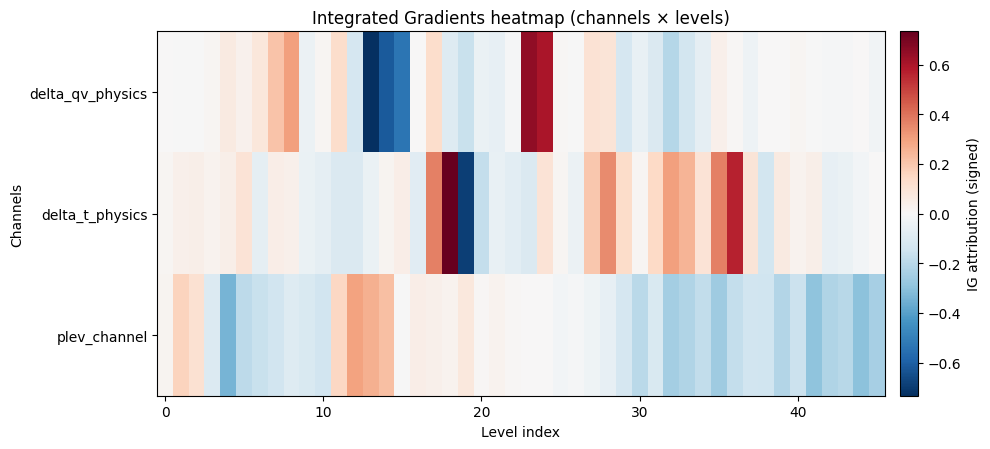

In [37]:
import matplotlib.pyplot as plt

C, L = attr_np.shape
vmax = np.percentile(np.abs(attr_np), 99) or 1.0  # robust color scaling

plt.figure(figsize=(10, 4 + 0.2*C))
im = plt.imshow(attr_np, aspect='auto', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
plt.colorbar(im, fraction=0.025, pad=0.02, label='IG attribution (signed)')
plt.xlabel('Level index')
plt.ylabel('Channels')

# If you have VAR_CHANNELS list, label rows:
try:
    from math import isfinite
    plt.yticks(ticks=np.arange(C), labels=VAR_CHANNELS)
except Exception:
    pass

plt.title('Integrated Gradients heatmap (channels × levels)')
plt.tight_layout()
plt.show()


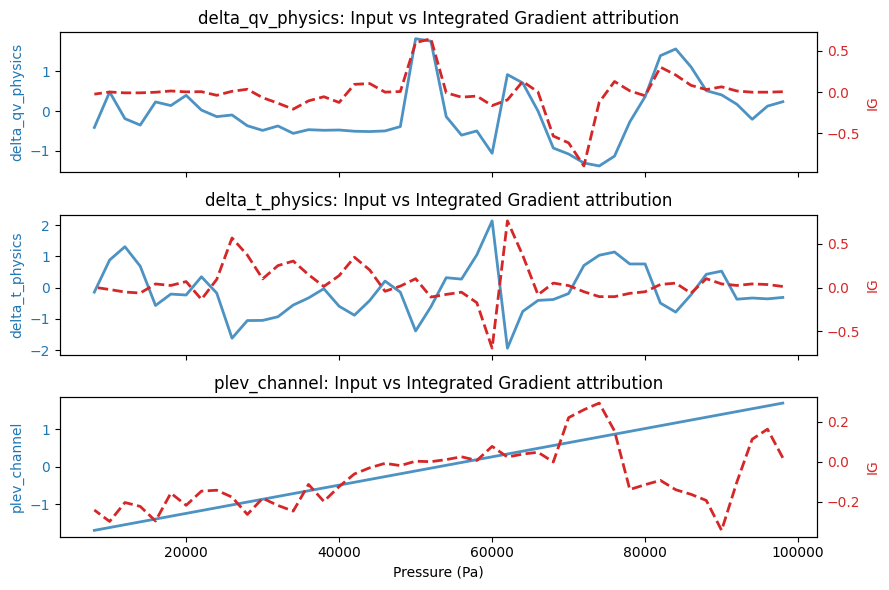

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- 1️⃣ Prepare attribution array (handles (1,C,L) or (1,C,1,L)) ---
attr = attributions_ig
if attr.dim() == 4:   # (1, C, 1, L)
    attr = attr.squeeze(0).squeeze(0)   # -> (C, L)
elif attr.dim() == 3: # (1, C, L)
    attr = attr.squeeze(0)
else:
    raise ValueError(f"Unexpected attr shape: {tuple(attr.shape)}")

attr_np = attr.detach().cpu().numpy()        # shape (C, L)
x_np = X_validation[-1]                            # actual variable values for the same sample (C, L)

# --- 2️⃣ Get variable names ---
try:
    var_names = VAR_CHANNELS
except NameError:
    var_names = [f"ch{i}" for i in range(attr_np.shape[0])]

# --- 3️⃣ Optional: get vertical coordinate for the x-axis ---
try:
    plev = ds_validation["plev"].values.astype(float)
    x_vals = plev
    x_label = "Pressure (Pa)"
except Exception:
    x_vals = np.arange(attr_np.shape[1])
    x_label = "Level index"

# --- 4️⃣ Plot each variable’s input + IG attribution ---
n_channels = len(var_names)
fig, axes = plt.subplots(n_channels, 1, figsize=(9, 2*n_channels), sharex=True)

for i, name in enumerate(var_names):
    ax = axes[i] if n_channels > 1 else axes
    ax2 = ax.twinx()

    # Plot the actual variable value
    ax.plot(x_vals, x_np[i], color="tab:blue", label="Input value", linewidth=2, alpha=0.8)
    ax.set_ylabel(name, color="tab:blue")
    ax.tick_params(axis='y', labelcolor="tab:blue")

    # Overlay the signed IG attribution
    ax2.plot(x_vals, attr_np[i], color="tab:red", linestyle="--", label="IG attribution", linewidth=2)
    ax2.tick_params(axis='y', labelcolor="tab:red")
    ax2.set_ylabel("IG", color="tab:red")

    ax.set_title(f"{name}: Input vs Integrated Gradient attribution")

axes[-1].set_xlabel(x_label)
plt.tight_layout()
plt.show()


In [ ]:
attributions_ig = integrated_gradients.attribute(validation_example, target='newlev', n_steps=200)

AssertionError: `inputs` must be a torch.Tensor or a tuple[torch.Tensor] but found: <class 'xarray.core.dataset.Dataset'>

In [ ]:
validation_example

<xarray.Dataset> Size: 5kB
Dimensions:            (newlev: 46, plev: 46, level: 127)
Coordinates:
  * plev               (plev) float64 368B 9.8e+04 9.6e+04 ... 1e+04 8e+03
  * level              (level) int64 1kB 0 1 2 3 4 5 ... 121 122 123 124 125 126
    lat                float32 4B 4.5
    model_id           int64 8B 1
    model_name         <U3 12B 'RAP'
    time               datetime64[ns] 8B 2016-09-09T21:00:00
    hour               int64 8B 21
Dimensions without coordinates: newlev
Data variables:
    pressure_f         (newlev) float64 368B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    delta_qv_dynamics  (newlev) float64 368B 0.2546 0.07637 ... -0.6423 0.02013
    delta_t_dynamics   (newlev) float64 368B -1.246 -0.4387 ... 0.924 -0.1708
    delta_u_dynamics   (newlev) float64 368B -1.096 -0.5323 ... 0.707 -1.434
    delta_v_dynamics   (newlev) float64 368B 0.2248 -0.06057 ... -0.1634 -0.7178
    delta_qv_physics   (newlev) float64 368B 0.2363 0.1257 ... 0.4799 -0.4107
    delta_u_physics    (newlev) float64 368B 0.785 0.4096 ... 0.4324 -3.092
    delta_v_physics    (newlev) float64 368B -0.2841 0.5578 ... 1.984 1.878
    delta_t_physics    (newlev) float64 368B -0.3142 -0.3605 ... 0.882 -0.1447
    plev_channel       (newlev) float32 184B 1.695 1.619 1.544 ... -1.619 -1.695

In [ ]:
validationing

SimpleLevelCNN(
  (net): Sequential(
    (0): Conv1d(3, 16, kernel_size=(15,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): AdaptiveAvgPool1d(output_size=1)
  )
  (head): Linear(in_features=32, out_features=2, bias=True)
)

In [23]:
X_train[0]

array([[-0.6765199 , -0.34324586, -0.45523402, -0.07715795,  0.8834536 ,
         1.0282272 ,  1.0686828 ,  2.0980742 ,  2.8544977 ,  0.6087774 ,
        -2.2435048 , -2.9554572 , -2.3415413 , -1.0072592 , -0.48289102,
         0.14077482,  1.4218848 ,  2.6404197 ,  2.5958083 ,  0.8828567 ,
        -0.620609  , -1.5765393 , -1.5930911 , -0.62433225,  0.32817498,
         0.98582876,  1.1463989 ,  0.7891291 ,  0.160638  ,  0.2401495 ,
         0.35258952,  0.4166043 ,  0.3439136 ,  0.31663063,  0.36071435,
        -0.11246684, -0.17371693, -0.99488   , -1.474202  , -1.8934438 ,
         0.66386604,  0.5613163 ,  2.4292018 ,  0.7775951 ,  0.13508108,
        -0.76181126],
       [-0.50806487, -0.48813534,  0.26781696,  0.97793025,  0.5933496 ,
         0.8251847 ,  1.3777969 ,  0.75363916,  0.27988324,  1.9254905 ,
         3.5946698 ,  3.396633  , -0.6246372 , -2.6115506 , -1.0585594 ,
        -0.339809  ,  3.261186  ,  4.1489406 ,  3.8770442 ,  2.0081186 ,
        -0.989975  , -2.36474

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report


model.eval()
all_preds = []
all_probs = []
all_true  = []

with torch.no_grad():
    for Xb, yb in validation_loader:
        Xb = Xb.to(device)
        logits = model(Xb)                      # [B, num_classes]
        probs  = torch.softmax(logits, dim=1)   # convert to probabilities
        preds  = probs.argmax(dim=1).cpu().numpy()

        all_preds.append(preds)
        all_probs.append(probs.cpu().numpy())
        all_true.append(yb.numpy())

y_pred = np.concatenate(all_preds, axis=0)
y_prob = np.concatenate(all_probs, axis=0)      # shape [N, num_classes]
y_true = np.concatenate(all_true,  axis=0)
# Build a mapping from model_id -> model_name using coords in your xarray dataset
# These coords live on the `sample` dimension and are consistent across time.
id_to_name = {int(i): str(n) for i, n in zip(ds_validation["model_id"].values, ds_validation["model_name"].values)}
class_ids = sorted(id_to_name.keys())
class_names = [id_to_name[i] for i in class_ids]

print("Classes:", dict(zip(class_ids, class_names)))
cm_counts = confusion_matrix(y_true, y_pred, labels=class_ids)              # integer counts
cm_rownorm = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True) # each row sums to 1

print("Confusion matrix (counts):\n", cm_counts)
print("\nClassification report:\n", classification_report(y_true, y_pred, labels=class_ids, target_names=class_names, digits=3))



Classes: {0: 'GFS', 1: 'RAP'}
Confusion matrix (counts):
 [[39  1]
 [ 2 38]]

Classification report:
               precision    recall  f1-score   support

         GFS      0.951     0.975     0.963        40
         RAP      0.974     0.950     0.962        40

    accuracy                          0.963        80
   macro avg      0.963     0.962     0.962        80
weighted avg      0.963     0.963     0.962        80



In [11]:
gfs_col

<xarray.Dataset> Size: 813kB
Dimensions:            (init_time: 245, newlev: 46, plev: 46, level: 127)
Coordinates:
  * plev               (plev) float64 368B 9.8e+04 9.6e+04 ... 1e+04 8e+03
  * level              (level) int64 1kB 0 1 2 3 4 5 ... 121 122 123 124 125 126
    lat                float32 4B ...
Dimensions without coordinates: init_time, newlev
Data variables:
    pressure_f         (init_time, newlev) float64 90kB ...
    delta_qv_dynamics  (init_time, newlev) float64 90kB ...
    delta_t_dynamics   (init_time, newlev) float64 90kB ...
    delta_u_dynamics   (init_time, newlev) float64 90kB ...
    delta_v_dynamics   (init_time, newlev) float64 90kB ...
    delta_qv_physics   (init_time, newlev) float64 90kB ...
    delta_u_physics    (init_time, newlev) float64 90kB ...
    delta_v_physics    (init_time, newlev) float64 90kB ...
    delta_t_physics    (init_time, newlev) float64 90kB ...

In [3]:
ds_train

<xarray.Dataset> Size: 1MB
Dimensions:            (sample: 2, time: 200, newlev: 46, plev: 46, level: 127)
Coordinates:
  * time               (time) datetime64[ns] 2kB 2016-08-11 ... 2016-09-04T21...
  * plev               (plev) float64 368B 9.8e+04 9.6e+04 ... 1e+04 8e+03
  * level              (level) int64 1kB 0 1 2 3 4 5 ... 121 122 123 124 125 126
    lat                float32 4B 4.5
    model_id           (sample) int64 16B 0 1
    model_name         (sample) <U3 24B 'GFS' 'RAP'
Dimensions without coordinates: sample, newlev
Data variables:
    pressure_f         (sample, time, newlev) float64 147kB 9.8e+04 ... 8e+03
    delta_qv_dynamics  (sample, time, newlev) float64 147kB -0.0007096 ... -5...
    delta_t_dynamics   (sample, time, newlev) float64 147kB 0.01321 ... 1.357
    delta_u_dynamics   (sample, time, newlev) float64 147kB -2.269 ... -5.033
    delta_v_dynamics   (sample, time, newlev) float64 147kB 7.488 ... -1.697
    delta_qv_physics   (sample, time, newlev) float64 147kB -0.0002085 ... -2...
    delta_u_physics    (sample, time, newlev) float64 147kB -1.67 ... -0.3211
    delta_v_physics    (sample, time, newlev) float64 147kB -2.43 ... 0.09015
    delta_t_physics    (sample, time, newlev) float64 147kB -0.3152 ... 0.1117